In [1]:
import pandas as pd
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
tweet=pd.read_csv("https://raw.githubusercontent.com/edwardcqian/climate_change_sentiment/master/data/sample_data.csv")

In [4]:
tweet=tweet[['message','sentiment']]

In [5]:
tweet["message_with_stop"] = tweet.message.apply(lambda x: ' '.join(re.sub("(rt )|(RT )|(\#[a-zA-Z]+[a-zA-Z0-9]*)|(@[A-Za-z0-9\_]+)|(:)|(\w+:\/\/\S+)"," ",x).split()))

In [6]:
tweet_tokenizer = TweetTokenizer()
def remove_stop(tweet):
    tokens = tweet_tokenizer.tokenize(tweet)
    return ' '.join([token for token in tokens if token not in stopwords.words('english')])

In [7]:
tweet["message_without_stop"] = tweet.message_with_stop.apply(remove_stop)

In [8]:
tweet.sample(5)

,message,sentiment,message_with_stop,message_without_stop
36548,RT @GrahamY: Guardian identifies first extinct...,-1,Guardian identifies first extinction from clim...,Guardian identifies first extinction climate c...
15010,RT @irinnews: “Very little has been done to ta...,1,“Very little has been done to tackle the bigge...,“ Very little done tackle bigger threat regula...
37100,RT @robdelaney: .@FoxNews the $q$clit.$q$ Real...,-1,". the $q$clit.$q$ Real, or just another Obama ...",". $ q $ clit . $ q $ Real , another Obama ruse..."
1715,RT @CUTrumpsHate: In 2016 the fact that we hav...,1,In 2016 the fact that we have a presidential c...,In 2016 fact presidential candidate believe cl...
38902,"RT @johnspatricc: secretariatToday, the UN Cli...",0,"secretariatToday, the UN Climate Change Secret...","secretariatToday , UN Climate Change Secretari..."


In [9]:
tweet["sentiment"].value_counts()

 1    22962
 2     9276
 0     7715
-1     3990
Name: sentiment, dtype: int64

In [10]:
tweet=tweet.loc[tweet['sentiment']!=2]

In [11]:
tweet.sample(5)

,message,sentiment,message_with_stop,message_without_stop
41736,RT @CECHR_UoD: How climate change in arctic co...,1,How climate change in arctic could cause tsuna...,How climate change arctic could cause tsunamis...
3623,"Fight climate change, burn or flush your sneak...",1,"Fight climate change, burn or flush your sneak...","Fight climate change , burn flush sneakers !"
899,RT @NASA_ICE: Artist @ZariaForman flies with #...,1,"Artist flies with scientists over Antarctica, ...","Artist flies scientists Antarctica , capturing..."
43849,RT @FoEAustralia: Afternoon session at #NEM201...,1,Afternoon session at focussing on Everyday Lif...,Afternoon session focussing Everyday Life & Au...
8589,An excellent lecture at the Royal Society abou...,1,An excellent lecture at the Royal Society abou...,An excellent lecture Royal Society difference ...


In [12]:
tweet["sentiment"].value_counts()

 1    22962
 0     7715
-1     3990
Name: sentiment, dtype: int64

In [13]:
tweet['encoded_cat'] = tweet.sentiment.astype('category').cat.codes

In [14]:
tweet.sample(5)

,message,sentiment,message_with_stop,message_without_stop,encoded_cat
21873,One can only hope that the little we are doing...,1,One can only hope that the little we are doing...,One hope little prevent climate change decimat...,2
40590,Shoutout to global warming for this beautiful ...,0,Shoutout to global warming for this beautiful ...,Shoutout global warming beautiful weather $ q ...,1
16433,RT @markusoff: Kenney: since when did Albertan...,1,Kenney since when did Albertans look for excus...,Kenney since Albertans look excuses something ...,2
23835,@CivilSocietyOz US 90% population growth 10% e...,1,US 90% population growth 10% emissions growth ...,US 90 % population growth 10 % emissions growt...,2
40506,RT @MCOckenden: New paper on high frequency nu...,0,New paper on high frequency nutrient dynamics ...,New paper high frequency nutrient dynamics P t...,1


In [15]:
tweet.sentiment.value_counts(normalize=True)

 1    0.662359
 0    0.222546
-1    0.115095
Name: sentiment, dtype: float64

In [16]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34667 entries, 0 to 43942
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   message               34667 non-null  object
 1   sentiment             34667 non-null  int64 
 2   message_with_stop     34667 non-null  object
 3   message_without_stop  34667 non-null  object
 4   encoded_cat           34667 non-null  int8  
dtypes: int64(1), int8(1), object(3)
memory usage: 1.4+ MB


In [17]:
X=list(tweet['message_with_stop'])

In [18]:
y=list(tweet['encoded_cat'])

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42,stratify=y)
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size = 0.30, random_state = 142,stratify=y_train)



In [20]:
#!pip install transformers
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [21]:
train_encodings = tokenizer(X_train_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [22]:
import tensorflow as tf

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))

In [24]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [25]:
from transformers import TFDistilBertForSequenceClassification

#We classify two labels in this example. In case of multiclass 
# classification, adjust num_labels value
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
history = model.fit(train_dataset.shuffle(100).batch(16),
          epochs=10,
          batch_size=16,
          validation_data=val_dataset.shuffle(100).batch(16))

Epoch 1/10
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
1214/1214 [==============================] - 349s 281ms/step - loss: 0.6218 - accuracy: 0.7452 - val_loss: 0.5388 - val_accuracy: 0.7804
Epoch 2/10
1214/1214 [==============================] - 342s 282ms/step - loss: 0.3813 - accuracy: 0.8515 - val_loss: 0.5793 - val_accuracy: 0.7844
Epoch 3/10
1214/1214 [==============================] - 342s 281ms/step - loss: 0.2028 - accuracy: 0.9292 - val_loss: 0.7154 - val_accuracy: 0.7740
Epoch 4/10
1214/1214 [==============================] - 342s 282ms/step - loss: 0.1160 - accuracy: 0.9610 - val_loss: 0.8879 - val_accuracy: 0.7724
Epoch 5/10
1214/1214 [==============================] - 342s 282ms/step - loss: 0.0775 - accuracy: 0.9728 - val_loss: 0.7751 - val_accuracy: 0.7776
Epoch 6/10
1214/1214 [==============================] - 341s 281ms/step - loss: 0.0602 - accuracy: 0.9805 - val_loss: 1.04

In [27]:
history_dict = history.history

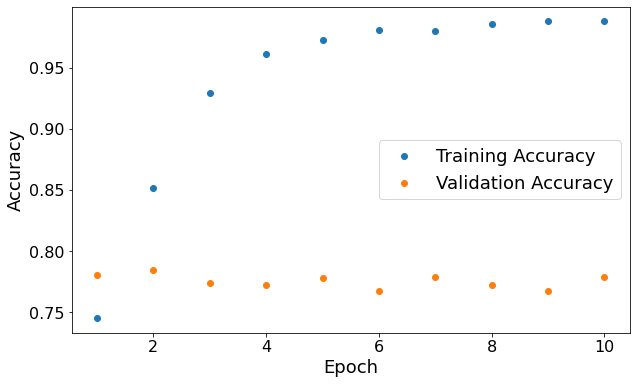

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))

plt.scatter(range(1,11), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,11), history_dict['val_accuracy'], label = "Validation Accuracy")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

In [101]:
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [102]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [103]:
predict = model.evaluate(test_dataset.shuffle(100).batch(16),
          return_dict=True,
          batch_size=16)

434/434 [==============================] - 20s 43ms/step - loss: 1.2580 - accuracy: 0.7710


In [104]:
test_encodings = tokenizer(X_test, truncation=True, padding=True)
dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings)))
preds = model.predict(dataset.batch(1)).logits  
    
res = tf.nn.softmax(preds, axis=1).numpy()

In [107]:
res.shape

(6934, 3)

In [109]:
import numpy as np
y_pred = np.argmax(res, axis=1)

In [110]:
y_pred.shape

(6934,)

In [111]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[ 511,   90,  197],
       [ 195,  736,  612],
       [ 175,  319, 4099]], dtype=int64)

In [ ]:
model.save_pretrained("/tmp/stance_custom_model")

In [27]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
